# Learning from Data: Workshop 6

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
|27th February 2015  | **12:00 Monday 23rd March 2015** |




Note that both paper (BART) and electronic submissions are required.

Candidate number: ** 033456 **  

Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

In [1]:
%pylab
%matplotlib inline
figsize(10, 8)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Decision boundaries and the Bayes error rate

The Bayes error rate is the minimum error rate that can be achieved with perfect knowledge of the probability distributions involved.  In this exercise we will assume that the *class conditional probability densities* are known and are one-dimensional Gaussian densities:
\begin{align*}
p(x | C_0) = \mathcal{N}(x; \mu_0, \sigma^2_0)\\
p(x | C_1) = \mathcal{N}(x; \mu_1, \sigma^2_1)
\end{align*}
For convenience, take $\mu_0 = 0$, $\mu_1 = 3.2$ and $\sigma^2_i = 1$ for $i = 0, 1$.  Remember that these are the probability that we observe a feature $x$, given that we know the class of the feature.

We will take the *prior probabilities* $p(C_0)$ and $p(C_1)$ to be $0.3$ and $0.7$ respectively.  These are the probabilities that an observation is in one class or the other before we have observed the actual data point.

### Data generation

We can generate some data from this model.  The procedure is:

    for each data point:
        draw the class, t, according to the prior probabilities
        draw the feature, x, from a Gaussian distribution with the mean and variance given by the class

Write a loop to generate vectors of pairs $x$ and $t$.  Draw lots of samples (say 10,000) and plot histograms (once for each class) of the samples (on the same plot) to make sure they correspond to your expectations.   With so many data points you'll be able to use plenty of bins (say 50 or 100); the second argument of <code>hist</code> controls the number of bins.

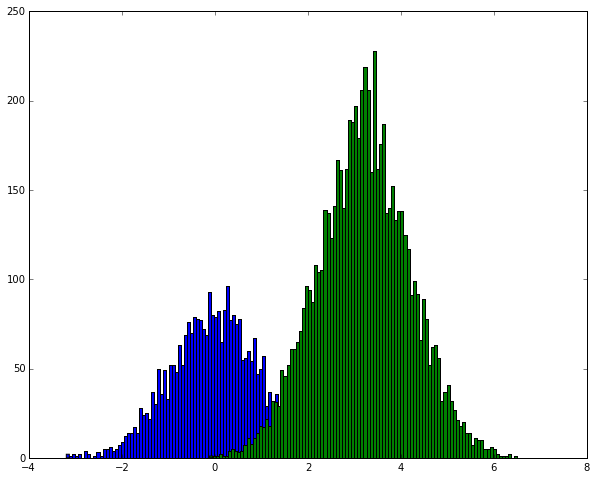

In [2]:
mu0 = 0.0
mu1 = 3.2
sigma = 1.0
p0 = 0.3
p1 = 1 - p0

t0 = 0
t1 = 1

# draw the class, t, according to the prior probabilities
T = np.random.choice(2, 10000, p=[p0, p1])
t0_count = sum(T == t0)
t1_count = sum(T == t1)
t0_arr = repeat(t0, t0_count)
t1_arr = repeat(t1, t1_count)

# draw the feature, x, from a Gaussian distribution with the mean and variance given by the class
X0 = randn(t0_count)*sqrt(sigma)+mu0
X1 = randn(t1_count)*sqrt(sigma)+mu1

# plot histograms for each class with 100 bins
hist(X0, bins=100)
hist(X1, bins=100)
print

> **Question:** Notice that the histograms you've plotted are proportional to $p(x | C_0) p(C_0)$ and $p(x | C_1) p(C_1)$.  Based on this, estimate by eye where the ideal decision boundary is.

> **Answer:**
Since the histograms are proportional to posterior probabilities, I'd estimate that the decision boundary lays at the intersection of the two histograms and is somewhere around 1.5 on the x-axis.

### Empirical error rate

To start, let's see how the empirical error rate varies as the decision boundary is varied.  Call the location of the decision boundary $\lambda$.  Then if $x_n < \lambda$ then $x_n$ is classified to $C_0$; otherwise it is classified to $C_1$.  

Make a plot of the how the accuracy of this simple classifier varies as the decision boundary $\lambda$ is varied from -6 to +10.  From your plot what is the optimal location of the decision boundary?  Does it concur with your "by eye" estimate in the previous cell?  What is an *estimate* of the Bayes error rate?

Programming gotcha: beware that <code>lambda</code> is a Python keyword, so you can't use that name (spelled like that) as a variable.

Optimal decision boundary is 1.316583 and it has accuracy of: 0.951700
Bayes error rate is: 0.048300




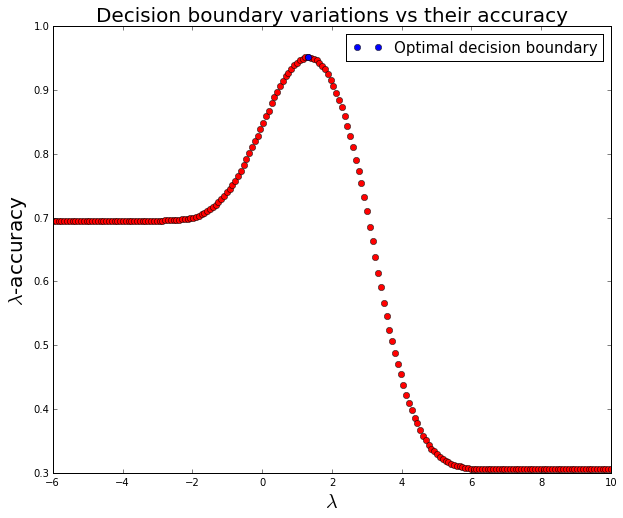

In [3]:
# concatenate C0 & C1 datasets for further use
x0_t0 = np.hstack([np.matrix(X0).T, np.matrix(t0_arr).T])
x1_t1 = np.hstack([np.matrix(X1).T, np.matrix(t1_arr).T])
X_t = np.concatenate((np.array(x0_t0), np.array(x1_t1)), axis=0) 

# generate a list of 200 lambda values between -6 & +10
lmbdas = linspace(-6, 10, 200)

best_accuracy = 0
optimal_lmbda = None

# loop over the list of lambdas to find one with the best accuracy
for lmbda in lmbdas:
    accuracy = 0
    for pair in X_t:
        if pair[0] < lmbda:
            x_class_guess = t0
        else:
            x_class_guess = t1
        
        if x_class_guess == pair[1]:
            accuracy+=1

    accuracy = accuracy/10000.0
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_lmbda  = lmbda

    # plot accuracy for this lambda
    plot(lmbda, accuracy, 'ro')

title('Decision boundary variations vs their accuracy', fontsize=20)
ylabel('$\lambda$-accuracy', fontsize=20)
xlabel('$\lambda$', fontsize=20)
plot(optimal_lmbda, best_accuracy, 'bo', label='Optimal decision boundary')
legend(loc=1, fontsize=15)

print "Optimal decision boundary is %f and it has accuracy of: %f" % (optimal_lmbda, best_accuracy)
print "Bayes error rate is: %f" % (1-best_accuracy)
print
print

> **Question:** From your plot what is the optimal location of the decision boundary? Does it concur with your "by eye" estimate in the previous cell? What is an estimate of the Bayes error rate?

> **Answer:** The optimal decision boundary is the blue dot on the plot. While the decision boundary slightly varies each time the data is regenerated it is usually at $1.316$ and it has the accuracy of $0.9517$ out of $1$. The estimate for the *Bayes error rate* would then be $1 - 0.9517 = 0.0483$.

> The optimal decision boundary of $1.316$ does roughly concur with my "by eye" estimate which was $1.5$.

### Theory

Now we will find the Bayes error rate using our knowlegde of the distributions from which the data was generated. 

Using the formula for $p(x|C_i) = \mathcal{N}(x; \mu_i, \sigma^2_i)$, draw on the same plot $p(x | C_0) p(C_0)$ and $p(x | C_1) p(C_1)$.  The point at which these curves cross is the location of the ideal decision boundary (why)?

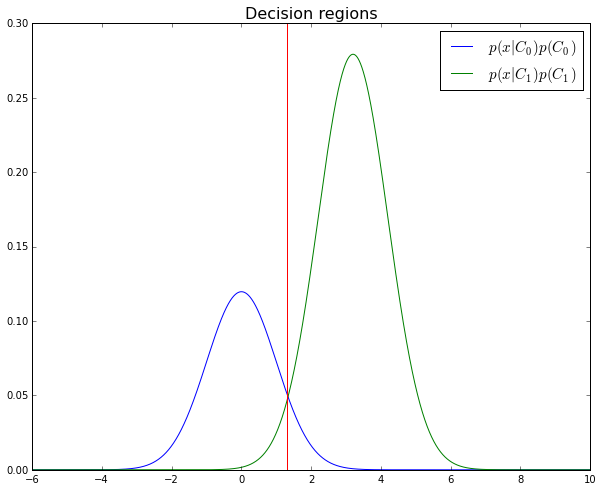

In [4]:
def normalpdf(x, mu, sigma):
    """Gaussian probability density in one dimension"""
    return exp(-(x-mu)**2/(2*sigma**2))/sqrt(2*pi*sigma)

px_c0 = normalpdf(linspace(-6, 10, 5000), mu0, sigma)
px_c1 = normalpdf(linspace(-6, 10, 5000), mu1, sigma)

plot(linspace(-6, 10, 5000), px_c0*p0, label="$p(x | C_0) p(C_0)$")
plot(linspace(-6, 10, 5000), px_c1*p1, label="$p(x | C_1) p(C_1)$")
# confirm that the optimal_boundary value found in the previous section
# is located at the intersection of the two curves:
plot([optimal_lmbda, optimal_lmbda], [0, 0.3], 'r')

title('Decision regions', fontsize=16)
legend(loc=1, fontsize=15)

> **Question:** The point at which these curves cross is the location of the ideal decision boundary (why)?

> **Answer:** The reason that ideal decision boundary is at the intersect of these two curves is because at that point the probability of making misclassification is the smallest. 

> When decision boundary is at the intersect, the only points that can be misclassified lie in the overlapping area between the two curves. This misclassification area is the theoretical limit of the error, it cannot be reduced further.

> However, if you place the boundary further to the left or to the right of the intersect, the probability of making a misclassification increases to the overlapping region between the two curver plus the little triangle-looking area bounded by the decision boundary and each of the two curves.

If, as before, the decision boundary is at $x = \lambda$, then the errors that are made in the classification of points in $C_0$ is $\int_{\lambda}^\infty p(x | C_0) p(C_0) dx$.  Since we know that $p(x | C_0)$ is a Gaussian density this integral can we worked out in terms of the (complementary) error function. 

Recall that 
\begin{align}
\int_t^\infty \mathcal{N}(x; 0, 1) dx = \frac{1}{2}\mbox{erfc}(\frac{t}{\sqrt{2}})
\end{align}
where $\mbox{erfc}(t)$ is the complementary error function, which the next cell plots.

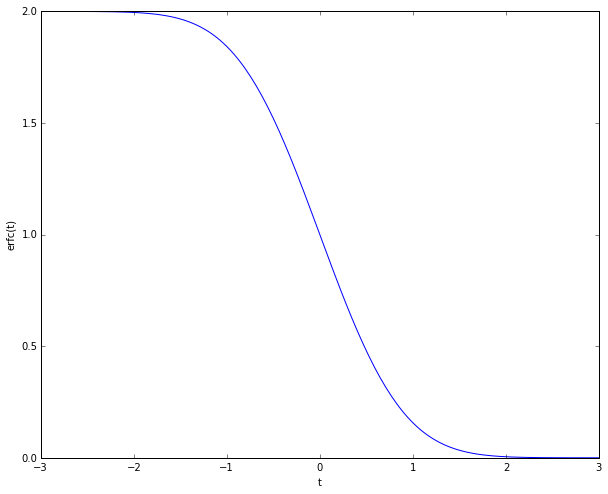

In [5]:
import scipy.special
t = linspace(-3, 3, 200)
plot(t, scipy.special.erfc(t))
xlabel('t')
ylabel('erfc(t)')

Use the complementary error function to draw a graph of the probability of making an error  in classifying  $C_0$ points as $\lambda$ is varied.  (Don't forget to account for the prior probability.)

Augment your graph with another curve, showing the probability of making an error in classifying $C_1$ points (you may find it easier to use the error function instead of the complementary error function).

Now plot the sum of these two curves, which is the total probability of making an error for any given $\lambda$.  Where is the best place for the decision boundary and what is the Bayes error rate?

Bayes error rate is: 0.049072


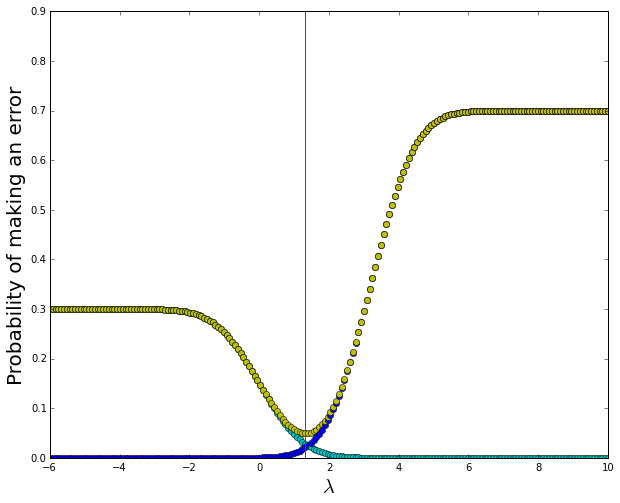

In [6]:
# probability in making error in classifying C0
def p_error_erfc(t):
    return 0.5*scipy.special.erfc(t/sqrt(2))

# probability in making error in classifying C1
def p_error_erf(t):
    return 0.5*(1+scipy.special.erf((t-3.2)/sqrt(2)))

lmbdas = linspace(-6, 10, 200)

bayes_error_rate = 999
optimal_lmbda = None

for lmbda in lmbdas:
    plot(lmbda, p_error_erfc(lmbda)*p0, 'co')
    plot(lmbda, p_error_erf(lmbda)*p1, 'bo')
    # the sum of the two curves: total probability of making an error for any given λ
    p_error_sum = p_error_erfc(lmbda)*p0+p_error_erf(lmbda)*p1
    plot(lmbda, p_error_sum, 'yo')
    
    if bayes_error_rate > p_error_sum:
        bayes_error_rate = p_error_sum
        optimal_lmbda  = lmbda

ylabel('Probability of making an error', fontsize=20)
xlabel('$\lambda$', fontsize=20)


plot([optimal_lmbda, optimal_lmbda], [0, 0.9], 'r')
print "Bayes error rate is: %f" % bayes_error_rate

> **Question:** Where is the best place for the decision boundary and what is the Bayes error rate?

> **Answer:** The best place for a decision boundary is where the total probability of making an error for any given $\lambda$ is at its lowest. On the graph above, it's at the very bottom of the yellow curve. In fact, the value of total probability at that point equals the Bayes error rate that is $0.049072$.

> It is worth noting that the total probability of making an error curve is essentialy the horizontally flipped accuracy curve plotted in the "Empirical error rate" section above. Moreover, the Bayes error rate value here roughly equals **`best_accuracy`** value that was also computed in the "Empirical error rate" section above.

### Posterior probabilities

Since we know the class conditional probabilities, we can use Bayes rule to work out the posterior probabilities exactly.  Use Bayes rule (see the lecture slides) to plot graphs of the posterior probabilities $p(C_i | x)$ for $ i = 0, 1$.  Check that these cross at the Bayes optimal decision boundary.  


Rejection region between 0.847186 and 1.785979


Fraction of the data rejected: 9.940000%


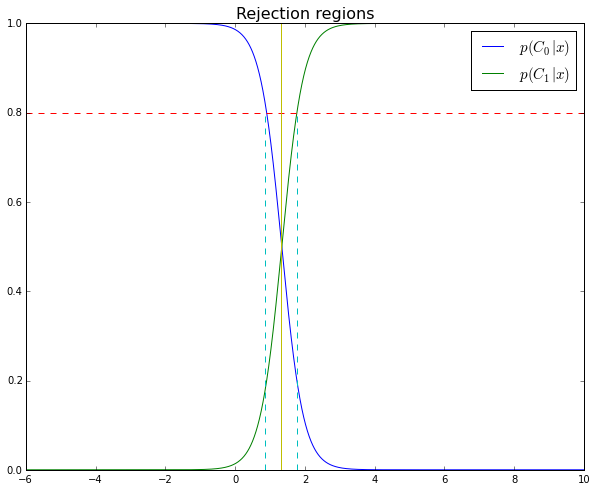

In [10]:
pc0_x = px_c0*p0/(px_c0*p0+px_c1*p1)
pc1_x = px_c1*p1/(px_c0*p0+px_c1*p1)

plot(linspace(-6, 10, 5000), pc0_x, label="$p(C_0 | x)$")
plot(linspace(-6, 10, 5000), pc1_x, label="$p(C_1 | x)$")

# plot 80% confidence line
plot(linspace(-6, 10, 2), [0.8, 0.8], '--')
# plot intersects of the .80 confidence with the posterior probability curves
c0_intersect = normalpdf(0.8, mu0, sigma)*p0/(normalpdf(0.8, mu0, sigma)*p0+normalpdf(0.8, mu1, sigma)*p1)
c1_intersect = optimal_lmbda*2-c0_intersect
plot([c0_intersect, c0_intersect], [0.0, 0.8], 'c--')
plot([c1_intersect, c1_intersect], [0.0, 0.8], 'c--')

print
print "Rejection region between %f and %f" % (c0_intersect, c1_intersect)
print
print

title('Rejection regions', fontsize=16)
legend(loc=1, fontsize=15)

# Check that these cross at the Bayes optimal decision boundary
plot([optimal_lmbda, optimal_lmbda], [0, 1], 'y')

# what fraction of data is rejected?
rejects = 0
for pair in X_t:
    if c1_intersect > pair[0] and pair[0] > c0_intersect:
        rejects+=1
        
print "Fraction of the data rejected: %f%%" % (rejects*100/float(10000))

### Rejection region

> **Question:** If you want to only classify examples that you are more than 80% confident of, where should the rejection lie?   In this case, what fraction of data is rejected?

> **Answer:** To classify examples with more than $80\%$ confidence two rejection lines should be placed at the intersection of both posterior probabilities and the straight line that goes through $0.8$. Everything in the rejion between those two lines has less than $80\%$ probability of being classified correctly and should therefore be rejected. On the graph above the rejection region roughly lies between $0.847$ and $1.786$.

> In this case I have computed that $9.94\%$ of data lies in the rejection region and has therefore been rejected.

### Receiver operating characteristics

In the "empirical error rate" cell above, you will have noticed that there is a trade-off between two sorts of errors: when $\lambda$ is negative, everything in $C_1$ is correctly classified, but at the expense of a poor classification rate for $C_0$.  The reverse is true when $\lambda$ is large and positive. 

A common way of viewing this trade-off is to focus on one of the classes, calling it the *positive class*.  Often we are more interested in one class than the other, for example, in spam classification we might designate emails that are spam as the positive class, in medical screening the condition that is being screened for is the positive class.  The types of classification that can be made are then:

* True positives: when $x$ is classified as positive and it is in fact positive;
* False positives: when $x$ is classified as positive, but is actually in the negative class.

Clearly, a good classifier will have a large true positive rate (the number of true positive classifications divided by the actual number of positive instances in the data) and a low false positive rate.

Make a plot of the true positive rate versus the false positive rate as $\lambda$ is varied from -6 to +10.  Use the set of 10,000 examples to get a nice smooth curve. This curve, which displays the range of available true and false positive rates, is known as the receiver operating characteristic or ROC curve.  It allows the user to select a decision boundary (here $\lambda$) that takes into account the relative costs of misclassification.  In general, the better the classifier, the greater the area under the ROC curve. 

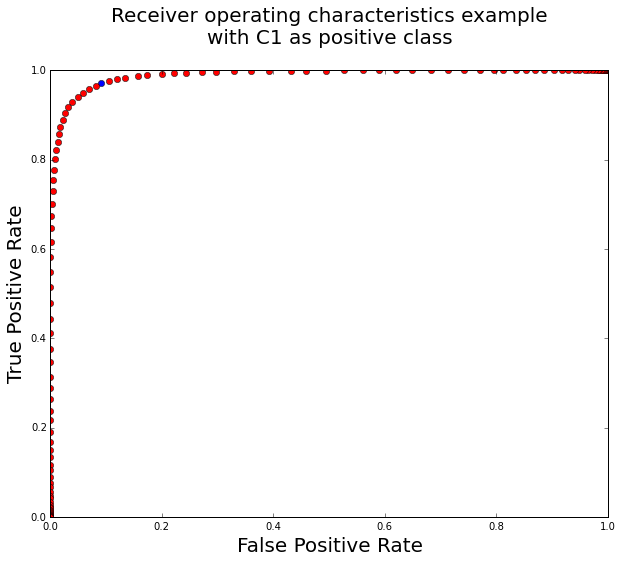

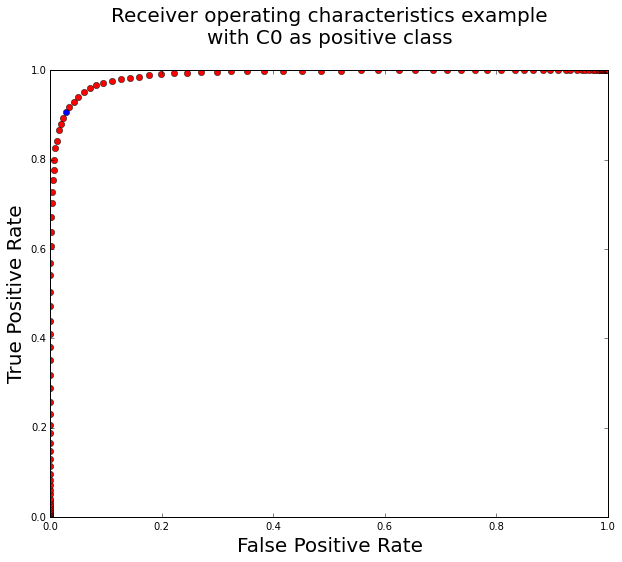

In [11]:
# Make a plot of the true positive plot choosing C1 as the positive class
for lmbda in lmbdas:
    true_positives = 0
    false_positives = 0
    
    for pair in X_t:
        if pair[0] < lmbda:
            x_class_guess = t0
        else:
            x_class_guess = t1
        
        if x_class_guess == t1 and pair[1] == t1:
            true_positives+=1
        elif x_class_guess == t1 and pair[1] == t0:
            false_positives+=1

    true_positives = true_positives / float(len(x1_t1))
    false_positives = false_positives / float(len(x0_t0))
    
    if lmbda == optimal_lmbda:
        plot(false_positives, true_positives, 'bo')
    else:
        plot(false_positives, true_positives, 'ro')
        
title('Receiver operating characteristics example\nwith C1 as positive class\n', fontsize=20)
ylabel('True Positive Rate', fontsize=20)
xlabel('False Positive Rate', fontsize=20)
figure()

# Make the same plot, but choose C0 as the positive class
for lmbda in lmbdas:
    true_positives = 0
    false_positives = 0
    
    for pair in X_t:
        if pair[0] < lmbda:
            x_class_guess = t0
        else:
            x_class_guess = t1
        
        if x_class_guess == t0 and pair[1] == t0:
            true_positives+=1
        elif x_class_guess == t0 and pair[1] == t1:
            false_positives+=1

    true_positives = true_positives / float(len(x0_t0))
    false_positives = false_positives / float(len(x1_t1))
    
    if lmbda == optimal_lmbda:
        plot(false_positives, true_positives, 'bo')
    else:
        plot(false_positives, true_positives, 'ro')
title('Receiver operating characteristics example\nwith C0 as positive class\n', fontsize=20)
ylabel('True Positive Rate', fontsize=20)
xlabel('False Positive Rate', fontsize=20)

> **COMMENTARY:** 
> For interest I've plotted two ROC curves choosing one of the two classes as the positive class in each case. The optimal lambda has been plotted on the graph as well and marked as blue. In both cases, as it is expected from an optimal lambda, it is located in the top left corner signifying large number of true positives and little number of false positives. The location of the optimal lambda is in a slightly different location on each graph.

> In both cases the area under the ROC curve is visually large and is approaching 1 which signifies that our classifier is of high accuracy yieleding a large number of true positives and just a few false positives.

## Classification with Support Vector Machines

Recall that SVMs are large margin classifiers, which use the *hinge loss* and can use kernels to effectively do  classification in a high-dimenional feature space. In the following you will use SVMs with a "linear kernel", that is without a kernel, and with an RBF kernel.  So that we can plot the decision boundaries, etc, we'll use a two dimensional dataset first and then work on a more realistic problem. 

Download and load the data in from two files.  The first file contains 250 data points for training data, while the second contains 1000 points for testing. There are lots of testing points which will allow you to assess how well a classifier is performing.

In [34]:
try: 
    train = loadtxt('gmm5train.txt')
except IOError:
    !curl -O  http://empslocal.ex.ac.uk/people/staff/reverson/ECM3420/gmm5train.txt
    train = loadtxt('gmm5train.txt')

try: 
    test = loadtxt('gmm5test.txt')
except IOError:
    !curl -O  http://empslocal.ex.ac.uk/people/staff/reverson/ECM3420/gmm5test.txt
    test = loadtxt('gmm5test.txt')


Xtr = train[:,:2]
ttr = train[:,2]
Xte = test[:,:2]
tte = test[:,2]

#%whos

As you've done for the tremor data, plot the training data by class. Is the data linearly separable?

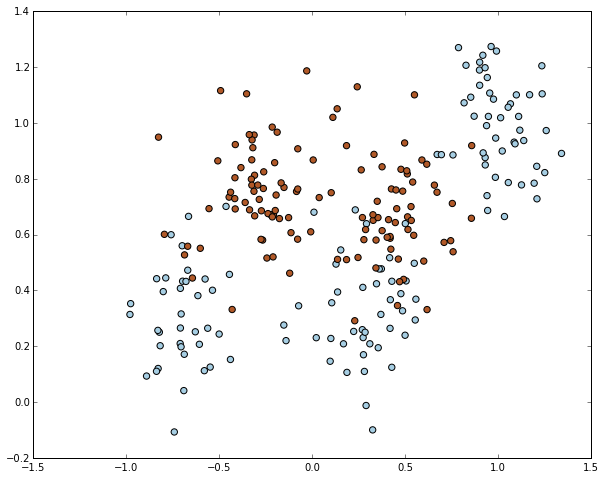

In [35]:
scatter(Xtr[:,0], Xtr[:,1], s=40, c=ttr, cmap=cm.Paired)

> **Question:** Is the data linearly separable?

> **Answer:** The given data is not linearly separable since both classes cannot be separated by a line or a hyperplane with high accuracy. As computed by the code below, the trained SVM's classification accuracy on the test data is actually less than 50% (i.e. roughly as accurate as randomly guessing the class).

We'll use the support vector machines in scikit learn.  Here's an example of training a SVM using a linear kernel (i.e., no non-linearity).

resulting classification accuracy on the training data 0.516
resulting classification accuracy on the test data: 0.495


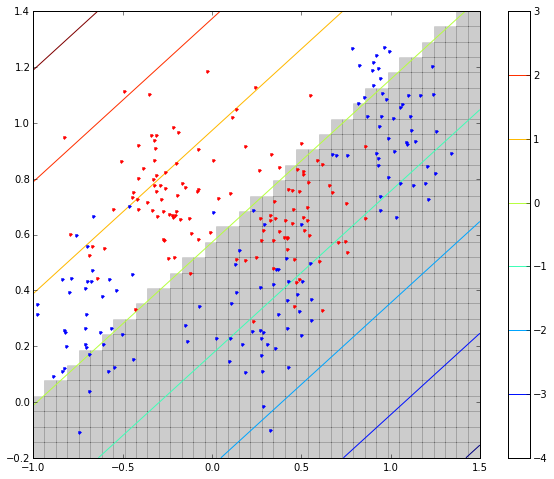

In [61]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')            # SVM with a linear kernel
svm.fit(Xtr, ttr)                     # Train it on the training data

# Plot the predictions (the two classes) for data on a grid and the discriminant
# function which is the distance from the decision plane
N = 40
M = 30
X = linspace(-1.0, 1.5, N)
Y = linspace(-0.2, 1.4, M)
pred = zeros((M,N))
disc = zeros((M,N))
for ny, y in enumerate(Y):
    for nx, x in enumerate(X):
        pred[ny, nx] = svm.predict([[x, y]])  # Predict expects a matrix of features
        disc[ny, nx] = svm.decision_function([[x, y]])  # Predict expects a matrix of features
pcolor(X, Y, pred, cmap=cm.gray, alpha=0.2)
contour(X, Y, disc) 
colorbar()
plot(Xtr[ttr==0,0], Xtr[ttr==0,1], 'b.')
plot(Xtr[ttr==1,0], Xtr[ttr==1,1], 'r.')
axis('tight')

pred = svm_grid.predict(Xtr)
print "resulting classification accuracy on the training data", accuracy_score(ttr, pred)

# What is the resulting accuracy on the test data?
pred = svm_grid.predict(Xte)
print "resulting classification accuracy on the test data:", accuracy_score(tte, pred)



# For given C & gamma plots the graph of RBF SVM trained on Xtr & ttr
def plot_rbf_classifier(C, gamma, Xtr, ttr):
    svm = SVC(kernel='rbf', C=C, gamma=gamma)
    svm.fit(Xtr, ttr)                     # Train it on the training data

    # Plot the predictions (the two classes) for data on a grid and the discriminant
    # function which is the distance from the decision plane
    N = 40
    M = 30
    X = linspace(-1.0, 1.5, N)
    Y = linspace(-0.2, 1.4, M)
    pred = zeros((M,N))
    disc = zeros((M,N))
    for ny, y in enumerate(Y):
        for nx, x in enumerate(X):
            pred[ny, nx] = svm.predict([[x, y]])  # Predict expects a matrix of features
            disc[ny, nx] = svm.decision_function([[x, y]])  # Predict expects a matrix of features
    figure()
    pcolor(X, Y, pred, cmap=cm.gray, alpha=0.2)
    contour(X, Y, disc) 
    colorbar()
    plot(Xtr[ttr==0,0], Xtr[ttr==0,1], 'b.')
    plot(Xtr[ttr==1,0], Xtr[ttr==1,1], 'r.')
    axis('tight')

Now use the SVM with <code>kernel='rbf'</code> to classify the data, but with a non-linear mapping so that the decision boundary can be non-linear. 

In this case the SVM has two additional parameters $C > 0$ and $\gamma$.  $C$ controls how strongly points that lie on the wrong side of the decision boundary are penalised.  When $C$ is large, they are heavily penalised which results in the boundary being flexible, but when it is small they are lightly penalised so the boundary tends to be straighter.  You can set the value of $C$ (and $\gamma$) with

        svm = SVC(kernel='rbf', C=1, gamma=0.1) 

The default value of $C$ is 1 and the default value of $\gamma$ is 0.1.

The $\gamma$ parameter controls the width of the RBF kernel, that is how close training samples must be to interact with each other (recall the effect of the width of basis functions in RBF regression).  When $\gamma$ is large the training samples must be close to interact and the decision boundary tends to be nonlinear, whereas when $\gamma$ is small it tends to be smooth.

Use cross validation on the *training* data to choose the best value of $C$ and $\gamma$.  Try a few values of $C$ and $\gamma$ by hand first of all to find appropriate ranges and it will probably be best to vary them on a logrithmic scale.  You may care to investigate and use the sklearn helper functions for searching a grid of values for the best cross validation value: see <http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#example-svm-plot-rbf-parameters-py> or write your own!

What is the resulting accuracy on the test data?

> **Answer:** Before applying cross validation on the training data to find the best value among a range of C and gamma values I first decided to pick an appropriate domain of ranges for C and gamma. To do this I decicded to plot the effect of various C and gamma parameter combinations using rbf kernel SVM on the accuracy of classification. This would allow me to see which domain of values perform well and which should be discarded.

> Function **`visualize_param_effect`** below produces a classification plot for each combination in the passed **`C_range`** and **`gamma_range`** allowing for a quick overview of accuracy values which are printed below each graph. The function also plots a heatmap matrix of accuracies for all the combinations allowing to get a quick glance how well given ranges perform. 

> So to start, I decided to plot effect graphs for **`C_range = logspace(-3, 3, 3)`** and **`gamma_range = logspace(-3, 3, 3)`**:

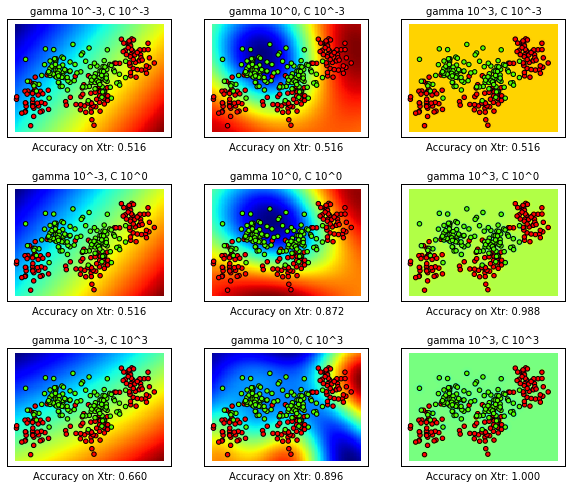

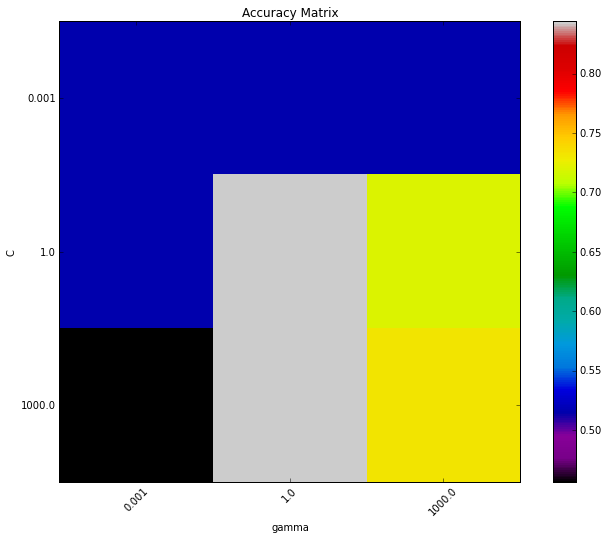

In [37]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

# Plot the effect of each combination in the passed C_range and gamma_range
# on classifying Xtr using rbf kernel SVM
# Based on code from the recommended scikit-learn.org link above
def visualize_param_effect(C_range, gamma_range, Xtr, ttr):
    # Train RBF SVM using the passed C_range and gamma_range
    C_range = C_range
    gamma_range = gamma_range
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedKFold(y=ttr, n_folds=5)
    svm_grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    svm_grid.fit(Xtr, ttr)


    # visualize effect of different parameters
    classifiers = []
    for C in C_range:
        for gamma in gamma_range:
            clsf = SVC(C=C, gamma=gamma)
            clsf.fit(Xtr, ttr)
            classifiers.append((C, gamma, clsf))

    figure()
    xx, yy = np.meshgrid(np.linspace(-1, 1.5, 100), np.linspace(-0.2, 1.5, 100))
    for (k, (C, gamma, clsf)) in enumerate(classifiers):
        # evaluate decision function in a grid
        Z = clsf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # visualize decision function for these parameters
        subplot(len(C_range), len(gamma_range), k + 1)
        title("gamma 10^%d, C 10^%d" % (np.log10(gamma), np.log10(C)), size='medium')
        xlabel("Accuracy on Xtr: %0.3f" % (accuracy_score(ttr, clsf.predict(Xtr))), size='medium')
        subplots_adjust(hspace=.4)
        # visualize parameter's effect on decision function
        pcolormesh(xx, yy, -Z, cmap=cm.jet)
        scatter(Xtr[:, 0], Xtr[:, 1], c=ttr, cmap=cm.prism)
        xticks(())
        yticks(())
        axis('tight')
        
    # plot the scores of the grid
    # grid_scores_ contains parameter settings and scores
    score_dict = svm_grid.grid_scores_

    # extract just the scores
    scores = [x[1] for x in score_dict]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))

    # draw heatmap of accuracy as a function of gamma and C
    figure()
    title('Accuracy Matrix')
    subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.95)
    imshow(scores, interpolation='nearest', cmap=cm.spectral)
    xlabel('gamma')
    ylabel('C')
    colorbar()
    xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    yticks(np.arange(len(C_range)), C_range)

    
visualize_param_effect(logspace(-3, 3, 3), logspace(-3, 3, 3), Xtr, ttr)

> As can be seen from the effect subplots above, 2/3 graphs where gamma values are in the $gamma=10^3$ domain overfit the data having extremely high classification accuracy which is not useful. Meanwhile the row of graphs where C values are around $C=10^-3$ produce poor classification accuracy. Similarly, the row of graphs where $gamma=10^-3$ also produce poor classification accuracy. Using this information we can learn to avoid using certain domains of C and gamma values (e.g. not to use high gammas as to not overfit the data).

> To iterate on this feedback I kept narrowing down the domain of ranges for `C_range` and `gamma_range` plotting the graphs again and again. Being able to iterate in this fashion I was able to come up with the domain of ranges for `C_range` and `gamma_range` that produced high classification accuracies without overfitting the training data and that were worth testing with the RBF SVM kernel.

> The final ranges are as following: **`C_range = logspace(-2, 0, 3)`** and **`gamma_range = logspace(0, 1, 3)`**:

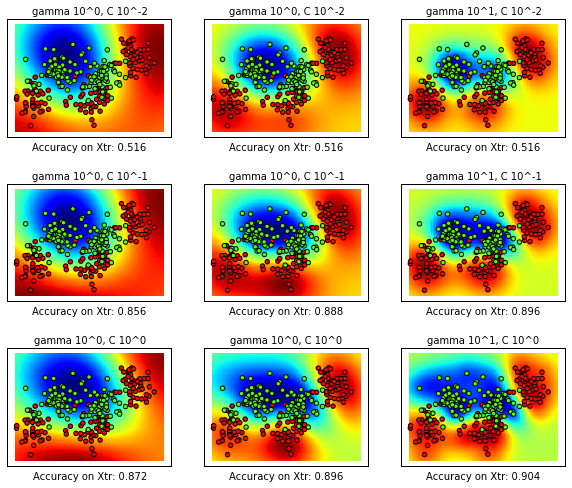

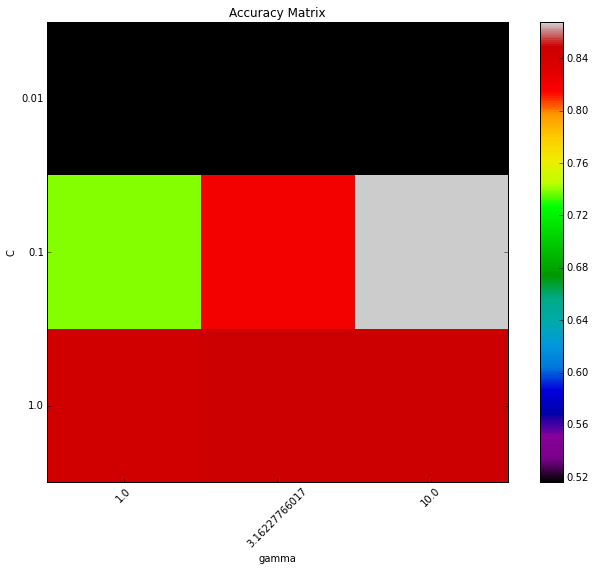

In [38]:
visualize_param_effect(logspace(-2, 0, 3), logspace(0, 1, 3), Xtr, ttr)

> Having chosen the C_range and gamma_range it is now time to train the SVM machine and pick the best C & gamma value from each range:

best C:  0.215443469003
best gamma:  3.5938136638
resulting classification accuracy on the training data 0.892
resulting classification accuracy on the test data: 0.902



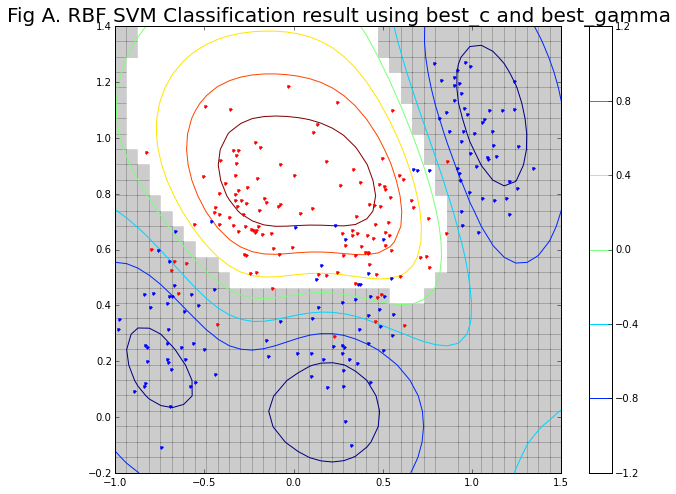

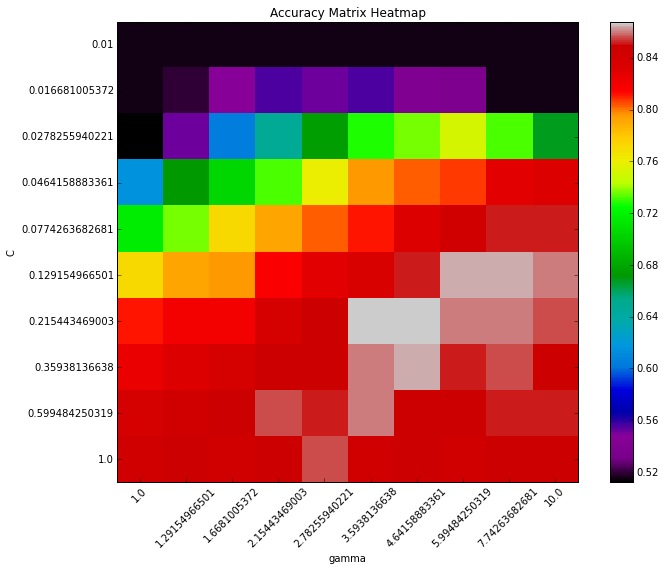

In [39]:
# Train RBF SVM classifier and use cross validation on the training set to get a stable estimation of parameters
C_range = logspace(-2, 0, 10)
gamma_range = logspace(0, 1, 10)
# values of C and gamma to iterate over
param_grid = dict(gamma=gamma_range, C=C_range)
# split training set into 5 folds for cross validation
cv = StratifiedKFold(y=ttr, n_folds=5)
svm_grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
svm_grid.fit(Xtr, ttr)

# find best value of C and gamma
best_c = svm_grid.best_estimator_.C
best_gamma = svm_grid.best_estimator_.gamma
print "best C: ", best_c
print "best gamma: ", best_gamma

pred = svm_grid.predict(Xtr)
print "resulting classification accuracy on the training data", accuracy_score(ttr, pred)

# What is the resulting accuracy on the test data?
pred = svm_grid.predict(Xte)
print "resulting classification accuracy on the test data:", accuracy_score(tte, pred)

# Draw best decision boundary from RBF kernel SVM
plot_rbf_classifier(best_c, best_gamma, Xtr, ttr)
title('Fig A. RBF SVM Classification result using best_c and best_gamma', fontsize=20)


# plot the scores of the grid
score_dict = svm_grid.grid_scores_

# extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# draw heatmap of accuracy as a function of gamma and C
figure()
title('Accuracy Matrix Heatmap')
subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.95)
imshow(scores, interpolation='nearest', cmap=cm.spectral)
xlabel('gamma')
ylabel('C')
colorbar()
xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
yticks(np.arange(len(C_range)), C_range)
print

> While training our SVM machine to find the best values of C and gamma we used additional cross validation on the training set. Using `StratifiedKFold` we partitioned our train data into 5 subsets in order to get a stable estimation of the parameters. I've chose to fold the data into 5 folds since that gave us the best classification accuracy for the test data: $0.902$. Choosing just 2 folds for example resulted in just $0.614$ accuracy.

> Having trained the SVM machine it produced the following estimates for `best_C` and `best_gamma` values:

> **`best_C:  0.215443469003`**

> **`best gamma:  3.5938136638`**

> Having learned the best C and gamma values I then applied that knowledge using our trained SVM machine to classify the test data. The resulting classification accuracy on the test data was a high $0.902$.

> Using newly learned `best_c` and `best_gamma` estimates I've then ploted the predictions for training data in the Fig A above using `plot_rbf_classifier` function defined earlier. The resulting classification seems to be indeed of high accuracy correctly drawing decision boundaries around 3 blue classes and 1 (almost 2) red classes.


> To show how accuracy varies between various combinations of C and gamma values I've printed the heatmap of the accuracy matrix. The best accuracy is the darkest red square that lies almost in the middle of the graph at the intersect of best_c and best_gamma. As can be observed from the heatmap, the combinations of C values in the range $0.2-1$ and gama values in the range $1-10$ all result in very high classification accuracy. It can then be observed that classification accuracy increases as gamma increases. While higher gamma values do sound lucrative to use, we have already observed earlier through the `visualize_param_effect` function that high gammas result in overfitted SVM classification which we would obviously like to avoid.

The distance from the decision boundary is a *score* and therefore can be used to construct an ROC curve.

Plot ROC curves for the linear and RBF SVMs on these data and find the respective areas under the ROC curves.  You may prefer to use the functions <code>roc_curve</code> and <code>roc_auc_score</code> in <code>sklearn.metrics</code> or write your own in a similar way to the first part of this workshop.


As might be expected, the RBF SVM achieves a much better ROC curve.

Area under the ROC curve for RBF SVM: 0.961163
Area under the ROC curve for linear SVM: 0.707162


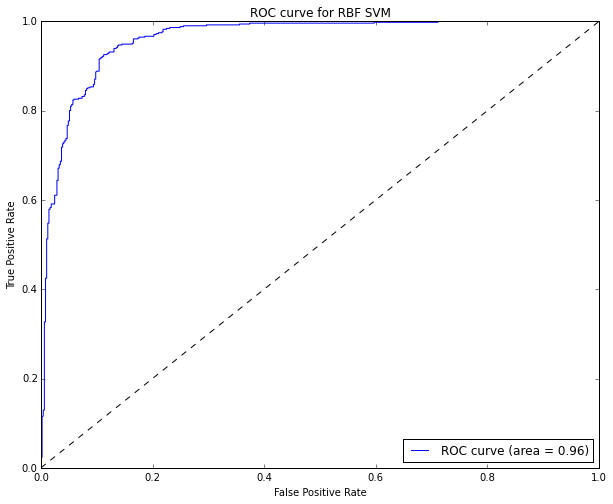

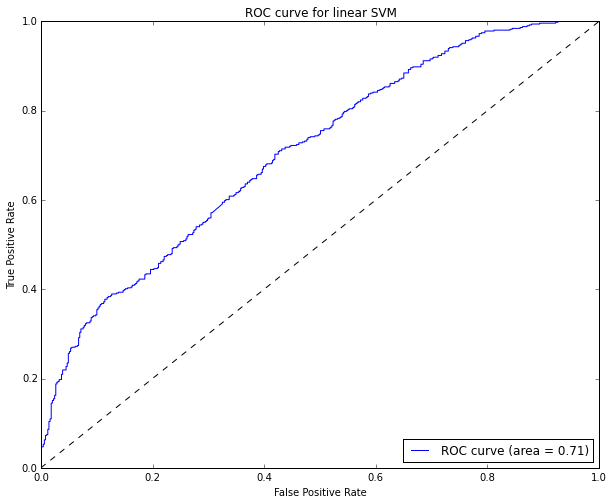

In [40]:
# Plot ROC curves for RBF SVM
from sklearn.metrics import roc_curve, auc
svm = SVC(kernel='rbf', C=best_c, gamma=best_gamma, probability=True)
probas_ = svm.fit(Xtr, ttr).predict_proba(Xte)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tte, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve for RBF SVM: %f" % roc_auc

# Plot ROC curve
clf()
plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], 'k--')
xlim([0.0, 1.0])
ylim([0.0, 1.0])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve for RBF SVM')
legend(loc="lower right")



# Plot ROC curves for Linear SVM
figure()
svm = SVC(kernel='linear', probability=True)
probas_ = svm.fit(Xtr, ttr).predict_proba(Xte)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tte, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve for linear SVM: %f" % roc_auc

# Plot ROC curve
clf()
plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], 'k--')
xlim([0.0, 1.0])
ylim([0.0, 1.0])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve for linear SVM')
legend(loc="lower right")

> **Q:** As might be expected, the RBF SVM achieves a much better ROC curve.

> **A:** Indeed, RBF SVM achieves a much better ROC curve than the linear SVM. The area under the RBF SVM ROC curve is larger than linear SVM's ROC curve by $0.25$ ($0.91-0.71$).

### Tremor data

Use linear and RBF kernel SVMs to classify the tremor data, drawing your best decision boundary.

classification accuracy on the training data using linear SVM: 0.865168539326
classification accuracy on the test data using linear SVM: 0.871508379888

best C:  0.001
best gamma:  2.15443469003
classification accuracy on the training data using RBF SVM: 0.842696629213
classification accuracy on the test data using RBF SVM: 0.832402234637



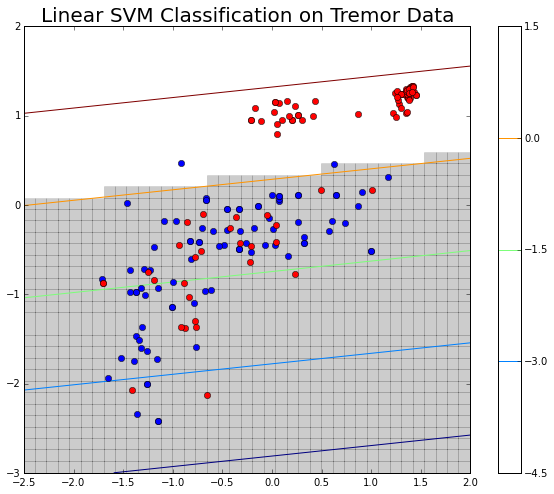

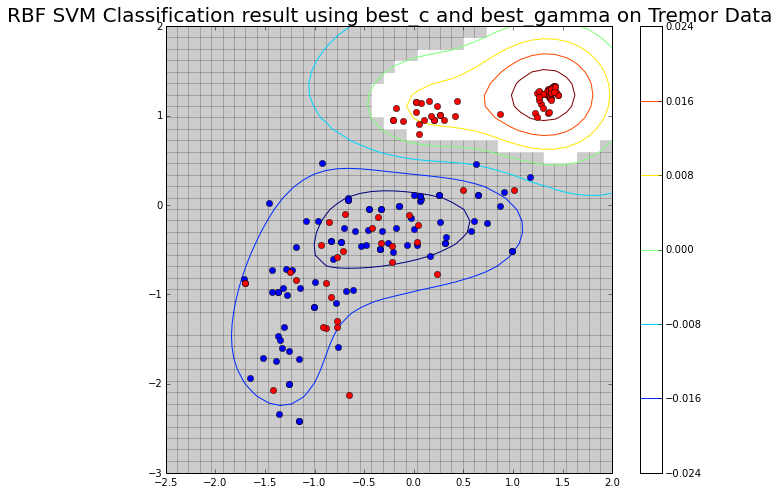

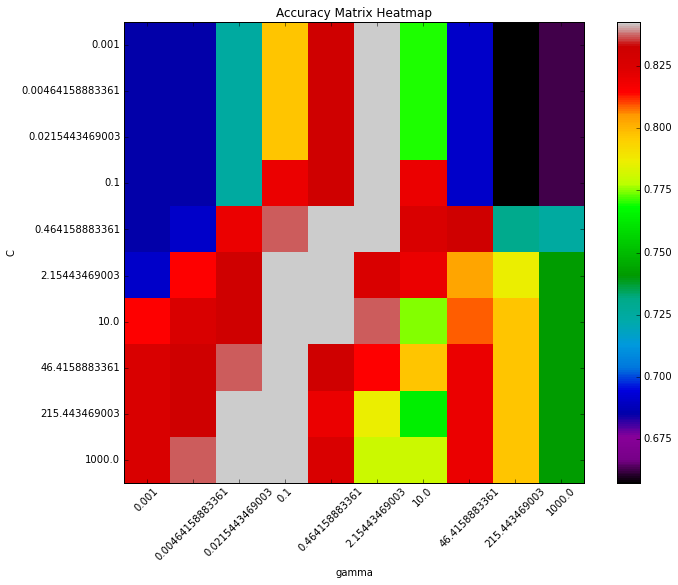

In [69]:
# Load tremor data
try: 
    X_tremor = loadtxt('raw-tremor.txt')
except IOError:
    !curl -O http://empslocal.ex.ac.uk/people/staff/reverson/ECM3420/raw-tremor.txt
    X_tremor = loadtxt('raw-tremor.txt')

t_tremor = X_tremor[:,2]
X_tremor = X_tremor[:,:2]

# Standardise data since SVMs don't deal well with differently scaled data
xbar = mean(X_tremor, axis=0)
xstd = std(X_tremor, axis=0)
X_tremor = (X_tremor-xbar)/xstd


from random import shuffle
N_tremor = len(t_tremor)
I = range(N_tremor)
shuffle(I)

tr = I[:N_tremor//2]
te = I[N_tremor//2:]

# training set
Xtr_tremor = X_tremor[tr,:]
ttr_tremor = t_tremor[tr]

# testing set
Xte_tremor = X_tremor[te,:]
tte_tremor = t_tremor[te]


# classify tremor data using linear kernel SVM and draw the decision boundary
svm = SVC(kernel='linear')            # SVM with a linear kernel
svm.fit(Xtr_tremor, ttr_tremor)                     # Train it on the training data

N = 40
M = 40
X = linspace(-2.5, 2, N)
Y = linspace(-3, 2, M)
pred = zeros((M,N))
disc = zeros((M,N))
for ny, y in enumerate(Y):
    for nx, x in enumerate(X):
        pred[ny, nx] = svm.predict([[x, y]])  # Predict expects a matrix of features
        disc[ny, nx] = svm.decision_function([[x, y]])  # Predict expects a matrix of features

title('Linear SVM Classification on Tremor Data', fontsize=20)
pcolor(X, Y, pred, cmap=cm.gray, alpha=0.2)
contour(X, Y, disc) 
colorbar()
plot(Xtr_tremor[ttr_tremor==0,0], Xtr_tremor[ttr_tremor==0,1], 'bo')
plot(Xtr_tremor[ttr_tremor==1,0], Xtr_tremor[ttr_tremor==1,1], 'ro')
axis('tight')

pred = svm_grid.predict(Xtr_tremor)
print "classification accuracy on the training data using linear SVM:", accuracy_score(ttr_tremor, pred)

# What is the resulting accuracy on the test data?
pred = svm_grid.predict(Xte_tremor)
print "classification accuracy on the test data using linear SVM:", accuracy_score(tte_tremor, pred)
print 

# classify tremor data using RBF kernel SVM and draw the decision boundary
C_range = logspace(-3, 3, 10)
gamma_range = logspace(-3, 3, 10)
# values of C and gamma to iterate over
param_grid = dict(gamma=gamma_range, C=C_range)
# split training set into 5 folds for cross validation
cv = StratifiedKFold(y=ttr_tremor, n_folds=5)
svm_grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
svm_grid.fit(Xtr_tremor, ttr_tremor)

# find best value of C and gamma
best_c = svm_grid.best_estimator_.C
best_gamma = svm_grid.best_estimator_.gamma
print "best C: ", best_c
print "best gamma: ", best_gamma


pred = svm_grid.predict(Xtr_tremor)
print "classification accuracy on the training data using RBF SVM:", accuracy_score(ttr_tremor, pred)

# What is the resulting accuracy on the test data?
pred = svm_grid.predict(Xte_tremor)
print "classification accuracy on the test data using RBF SVM:", accuracy_score(tte_tremor, pred)

# Draw best decision boundary from RBF kernel SVM
svm = SVC(kernel='rbf', C=best_c, gamma=best_gamma)
svm.fit(Xtr_tremor, ttr_tremor)

N = 40
M = 40
X = linspace(-2.5, 2, N)
Y = linspace(-3, 2, M)
pred = zeros((M,N))
disc = zeros((M,N))
for ny, y in enumerate(Y):
    for nx, x in enumerate(X):
        pred[ny, nx] = svm.predict([[x, y]])
        disc[ny, nx] = svm.decision_function([[x, y]])  # Predict expects a matrix of features
figure()
title('RBF SVM Classification result using best_c and best_gamma on Tremor Data', fontsize=20)
pcolor(X, Y, pred, cmap=cm.gray, alpha=0.2)
contour(X, Y, disc)
colorbar()
plot(Xtr_tremor[ttr_tremor==0,0], Xtr_tremor[ttr_tremor==0,1], 'bo')
plot(Xtr_tremor[ttr_tremor==1,0], Xtr_tremor[ttr_tremor==1,1], 'ro')
axis('tight')





# plot the scores of the grid
score_dict = svm_grid.grid_scores_

# extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# draw heatmap of accuracy as a function of gamma and C
figure()
title('Accuracy Matrix Heatmap')
subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.95)
imshow(scores, interpolation='nearest', cmap=cm.spectral)
xlabel('gamma')
ylabel('C')
colorbar()
xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
yticks(np.arange(len(C_range)), C_range)
print

> Before proceeding with classifying the tremor data using SVM it had to be standardised since SVMs don't deal well with differently scaled data. I did this by subtracting the mean from the data and dividing it by standard deviation. Sphering might have been useful in standardising as well, but I didn't have time to try it.

> Further SVM classification procedure was exactly the same as in the previous section.

> Classification accuracies have been found using both linear and RBF SVMs. Given that Tremor data is more linearly separable than data in the previous section, SVM with linear kernel performed with the same if not better accuracy than RVM SVM.

> During one of the runs of the code above I was able to get the following classification accuracies for each kernel type:

> **classification accuracy using linear SVM on the:**

> **`training data`** : 0.865168539326

> **`test data`**     : 0.871508379888


> **classification accuracy using RBF SVM on the:**

> **`training data`** : 0.842696629213

> **`test data`**     : 0.832402234637


> While SVMs predict roughly with the same accuracy using either kernel, during that particular run, linear SVM outperformed RBF SVM by 4%.

> Plotting the ROC curves for both SVMs below further proves that not only do both kernel types perform roughly equaly, they also perform pretty well at classifying Tremor data with areas under either ROC curves being pretty close to 1.

Area under the ROC curve for RBF SVM: 0.881119
Area under the ROC curve for linear SVM: 0.833417


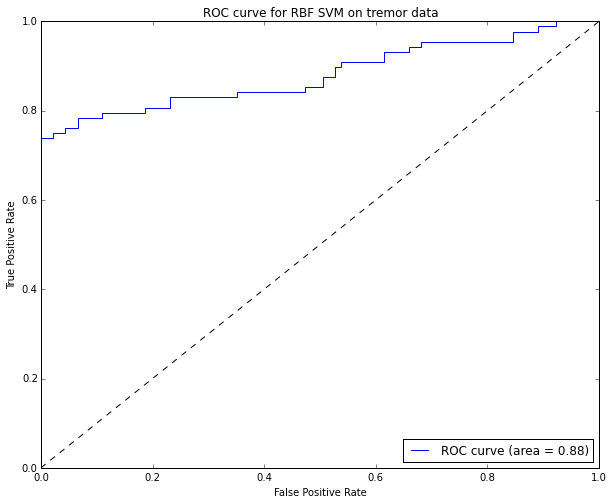

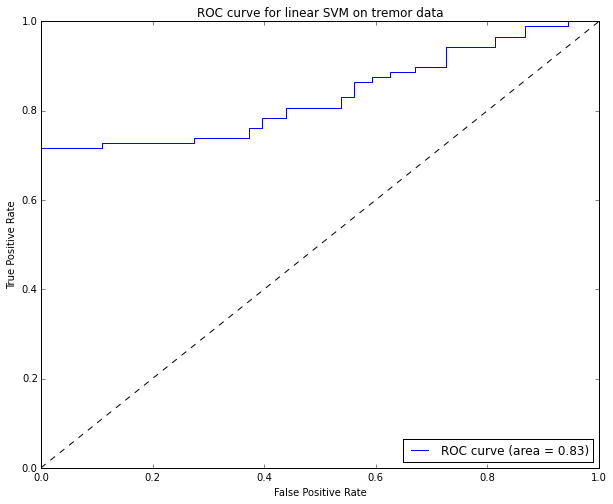

In [68]:
# Plot ROC curves for RBF SVM
from sklearn.metrics import roc_curve, auc
svm = SVC(kernel='rbf', C=best_c, gamma=best_gamma, probability=True)
probas_ = svm.fit(Xtr_tremor, ttr_tremor).predict_proba(Xte_tremor)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tte_tremor, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve for RBF SVM: %f" % roc_auc

# Plot ROC curve
clf()
plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], 'k--')
xlim([0.0, 1.0])
ylim([0.0, 1.0])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve for RBF SVM on tremor data')
legend(loc="lower right")



# Plot ROC curves for Linear SVM
figure()
svm = SVC(kernel='linear', probability=True)
probas_ = svm.fit(Xtr_tremor, ttr_tremor).predict_proba(Xte_tremor)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tte_tremor, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve for linear SVM: %f" % roc_auc

# Plot ROC curve
clf()
plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], 'k--')
xlim([0.0, 1.0])
ylim([0.0, 1.0])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve for linear SVM on tremor data')
legend(loc="lower right")

## SPAM

Detecting email spam is classification problem where it is important to control the true and false positive rates: you don't want too many false positives -- messages that are classified as spam when in fact they are genuine. 

This aim of this exercise is to construction and evaluate a spam classifier using a classifier of your choice, but I recommend a SVM; an RBF kernel doesn't do much better than a linear one in this case. The following cell will load the spam data.  There are 57 features and the class label.  These data come from the UCI machine learning database and there is some more information on the data at <https://archive.ics.uci.edu/ml/machine-learning-databases/spambase>, however, here is the relevant information from the documentation.

Most of the attributes (features) indicate whether a particular word or
character was frequently occuring in the e-mail.  The run-length
attributes (55-57) measure the length of sequences of consecutive 
capital letters.  Here are the definitions of the attributes:

* 48 continuous real [0,100] attributes of type word_freq_WORD 
 = percentage of words in the e-mail that match WORD,
 i.e. 100 * (number of times the WORD appears in the e-mail) / 
 total number of words in e-mail.  A "word" in this case is any 
 string of alphanumeric characters bounded by non-alphanumeric 
 characters or end-of-string.

* 6 continuous real [0,100] attributes of type char_freq_CHAR
 = percentage of characters in the e-mail that match CHAR,
 i.e. 100 * (number of CHAR occurences) / total characters in e-mail

* 1 continuous real [1,...] attribute of type capital_run_length_average
 = average length of uninterrupted sequences of capital letters

* 1 continuous integer [1,...] attribute of type capital_run_length_longest
 = length of longest uninterrupted sequence of capital letters

* 1 continuous integer [1,...] attribute of type capital_run_length_total
 = sum of length of uninterrupted sequences of capital letters
 = total number of capital letters in the e-mail

In the data supplied there are 1813  (39.4%) instances of spam (target = 1) and 2788  (60.6%) genuine/non-spam instances (target = 0). 


Build and test a classifier to classify the spam data into spam and genuine.  Exactly how you tackle this is up to you, but bear in mind the following.

* You will need to divide the data into training and test sets.  Make sure that you don't use the test data for training.
* As it will be important to control false positives you should plot ROC curves for your classifier.
* Support vector machines work much better if the features are O(1).  Most of the features in the data are larger than that, so you should standardise the features before classification.

classification accuracy on the training data using linear SVM: 0.95597826087
classification accuracy on the test data using linear SVM: 0.951140065147
Area under the ROC curve for linear SVM: 0.966073

best C:  1000.0
best gamma:  0.001
classification accuracy on the test data using RBF SVM: 0.960326086957
classification accuracy on the test data using RBF SVM: 0.940282301846
Area under the ROC curve for linear SVM: 0.966257


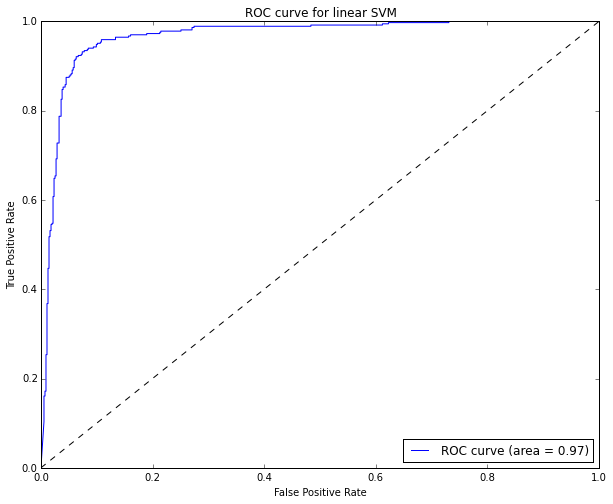

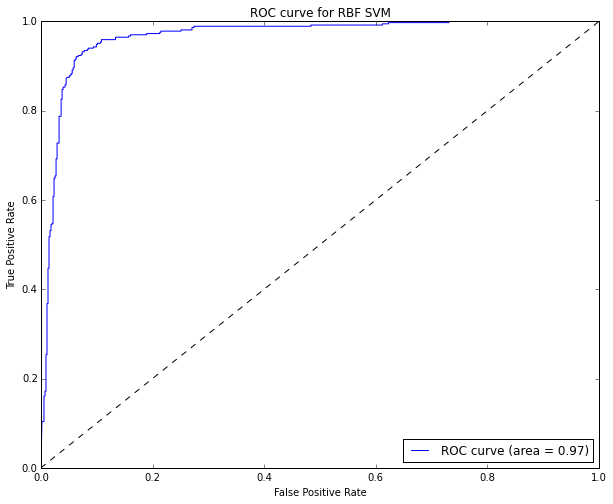

In [93]:
try: 
    spam = loadtxt('spambase.data', delimiter=',')
except IOError:
    !wget --no-verbose http://empslocal.ex.ac.uk/~reverson/ECM3420/spambase.data
    spam = loadtxt('spambase.data', delimeter=',')

X = spam[:,:-1]   # Features
t = spam[:,-1]    # Targets


# standerdise data
xbar = mean(X, axis=0)
xstd = std(X, axis=0)
X = (X-xbar)/xstd





# split data into training and test sets
from sklearn.cross_validation import train_test_split
Xtr, Xte, ttr, tte = train_test_split(X, t, test_size=0.2)


# Train linear SVM classifier
svm = SVC(kernel='linear')            # SVM with a linear kernel
svm.fit(Xtr, ttr)                     # Train it on the training data

pred = svm_grid.predict(Xtr)
print "classification accuracy on the training data using linear SVM:", accuracy_score(ttr, pred)

# What is the resulting accuracy on the test data?
pred = svm_grid.predict(Xte)
print "classification accuracy on the test data using linear SVM:", accuracy_score(tte, pred)

# Plot ROC curves for Linear SVM
figure()
svm = SVC(kernel='linear', probability=True)
probas_ = svm.fit(Xtr, ttr).predict_proba(Xte)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tte, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve for linear SVM: %f" % roc_auc
print 

# Plot ROC curve
clf()
plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], 'k--')
xlim([0.0, 1.0])
ylim([0.0, 1.0])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve for linear SVM')
legend(loc="lower right")




# Train RBF SVM classifier and use cross validation on the training set to get a stable estimation of parameters
C_range = logspace(-3, 3, 2)
gamma_range = logspace(-3, 3, 2)
# values of C and gamma to iterate over
param_grid = dict(gamma=gamma_range, C=C_range)
# split training set into 5 folds for cross validation
cv = StratifiedKFold(y=ttr, n_folds=5)
svm_grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
svm_grid.fit(Xtr, ttr)

# find best value of C and gamma
best_c = svm_grid.best_estimator_.C
best_gamma = svm_grid.best_estimator_.gamma
print "best C: ", best_c
print "best gamma: ", best_gamma

pred = svm_grid.predict(Xtr)
print "classification accuracy on the test data using RBF SVM:", accuracy_score(ttr, pred)

# What is the resulting accuracy on the test data?
pred = svm_grid.predict(Xte)
print "classification accuracy on the test data using RBF SVM:", accuracy_score(tte, pred)

# Plot ROC curves for RBF SVM
figure()
svm = SVC(kernel='linear', probability=True)
probas_ = svm.fit(Xtr, ttr).predict_proba(Xte)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tte, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve for linear SVM: %f" % roc_auc

# Plot ROC curve
clf()
plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], 'k--')
xlim([0.0, 1.0])
ylim([0.0, 1.0])
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve for RBF SVM')
legend(loc="lower right")


> Given a rather diverse scale of SPAM features' data we had to standardised it before proceeding with SVM classification. I did this by subtracting the mean from the data and dividing it by standard deviation. Sphering might have been even more useful in standardising the data points, but I didn't have time to try it.

> After standardising the data I split it into the usual training and testing sets allocating 20% of data to testing and 80% to training in order to have a well-trained SVM.

> I then proceeded to classify the data using both linear and RBF SVMs for comparison. As has been already noted in the exercise description RBF kernel indeed doesn't do much better than a linear one in the case of SPAM data. Having plotted ROC curves for both kernels this has been further confirmed since both graphs look roughly the same and the area under the ROC curve is roughly equal among the two.


> The difference between classification accuracies of using either method is also insignificant.

> The computed classification accuracy, as it can also be observed from the ROC curves, is a very high 0.93+ for both methods. While initially I thought that such high accuracy can probably be explained by our use of a very large training set in comparison to the testing set, but after trying much smaller training sets I still got highly accurate classifications. As such I believe that such a good result in classification accuracy can be attributed to the high quality of features in measuring the distinction between SPAMy and not SPAMy data.

> Among other things I could've done is to test the effect of reducing the number of dimenstions on the resulting accuracy. If I had more time I could've also plotted the learning curve in order to observe the effect of changing the training size on the resulring classification accuracy of the training data.